Skipping community detection for snapshot at 2019-09-04 23:00:00 due to ZeroDivisionError.
Skipping community detection for snapshot at 2020-03-07 07:00:00 due to ZeroDivisionError.


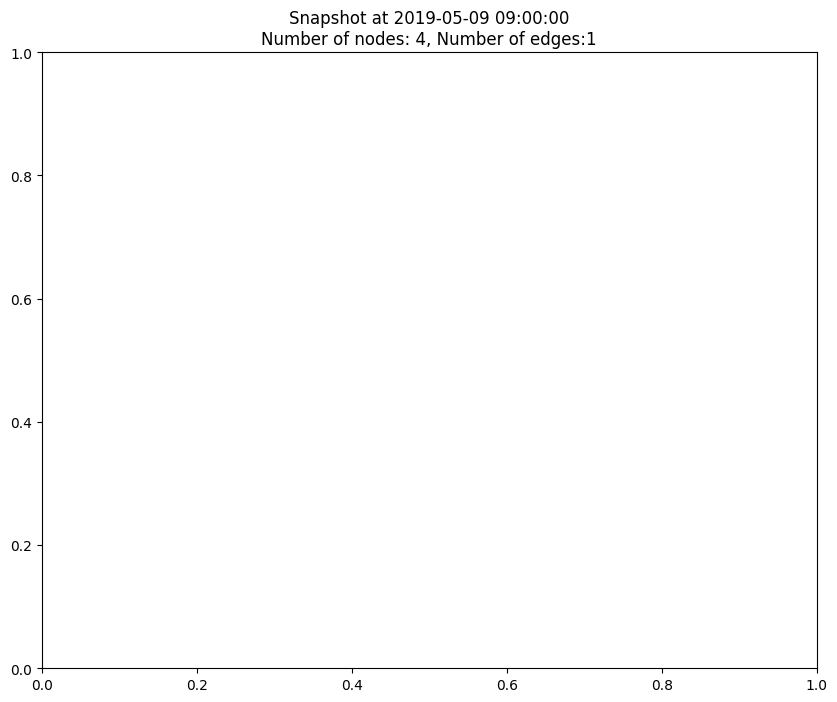

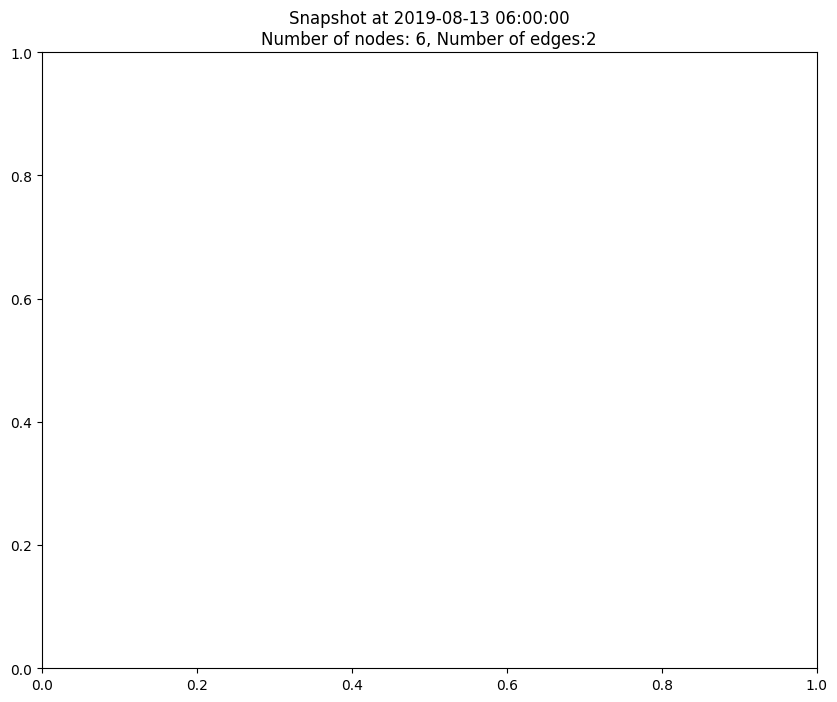

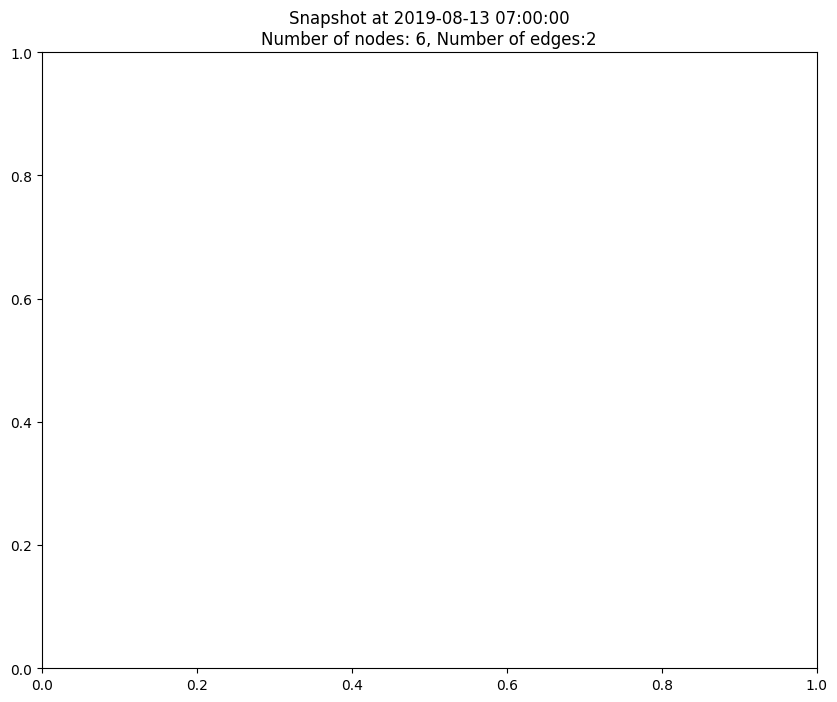

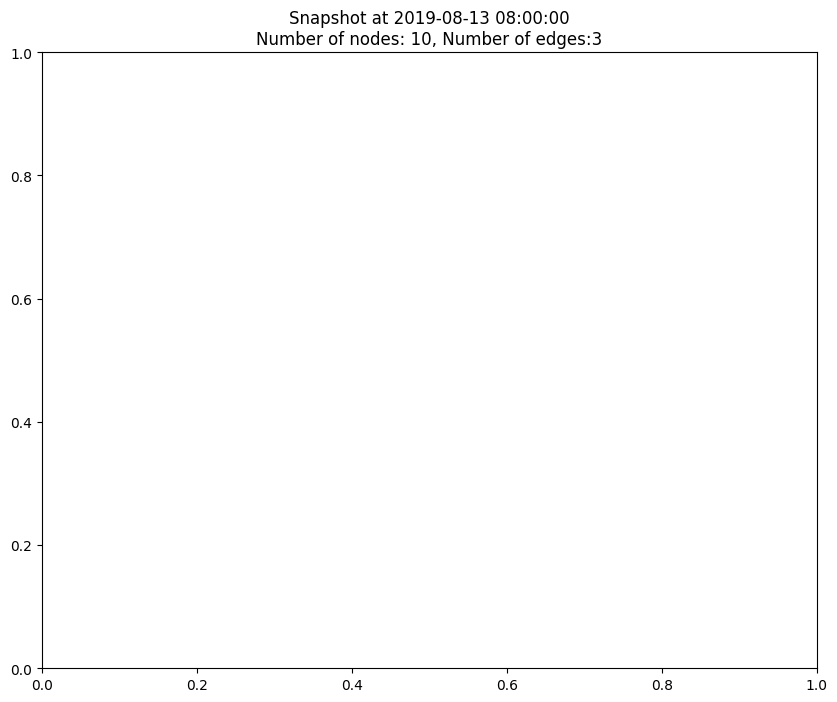

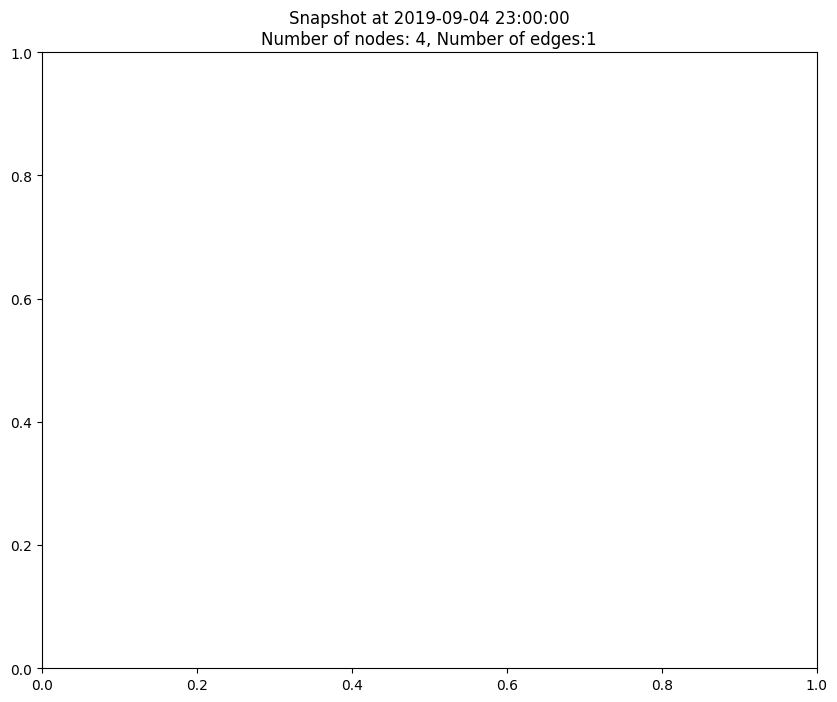

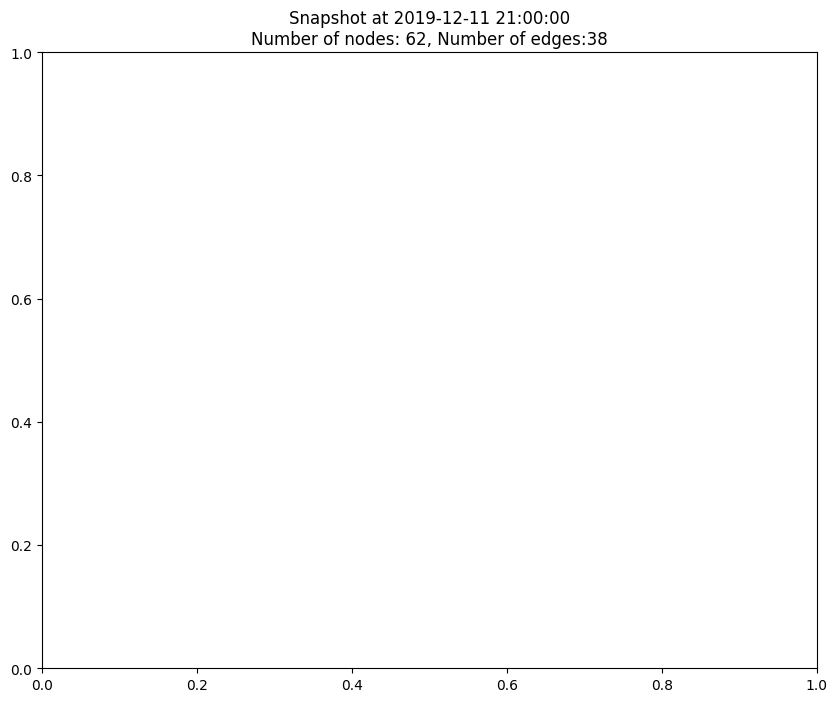

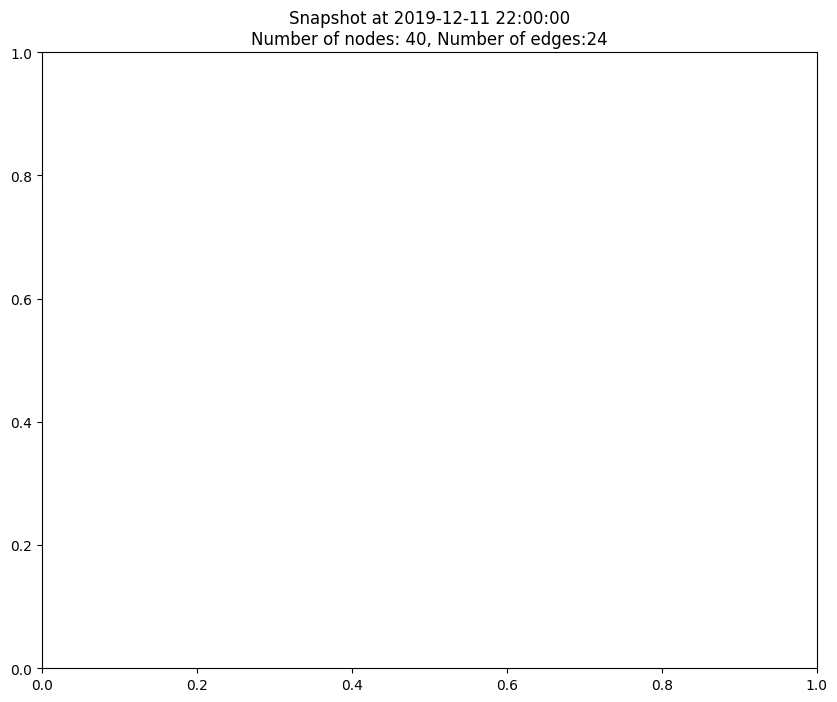

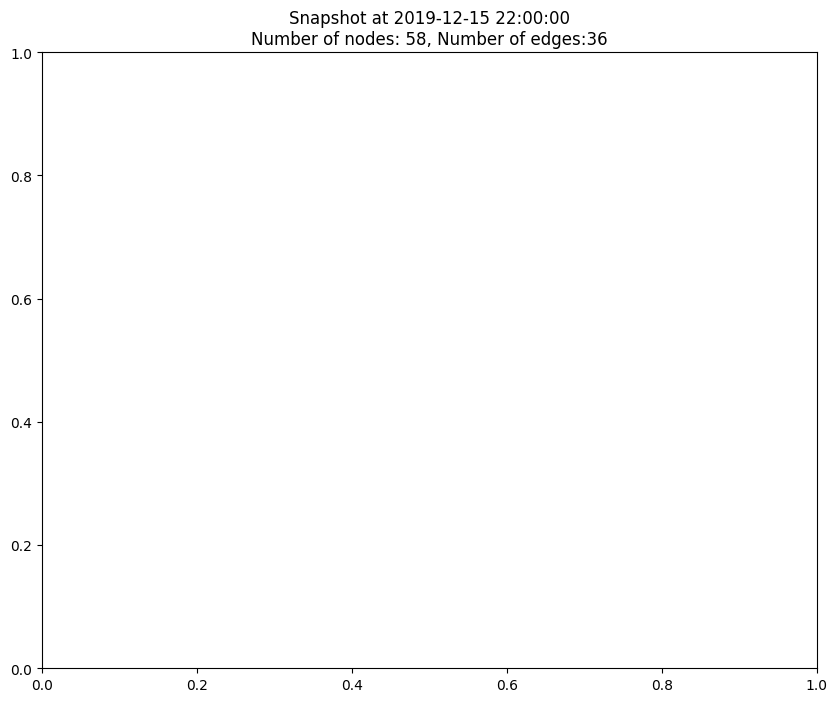

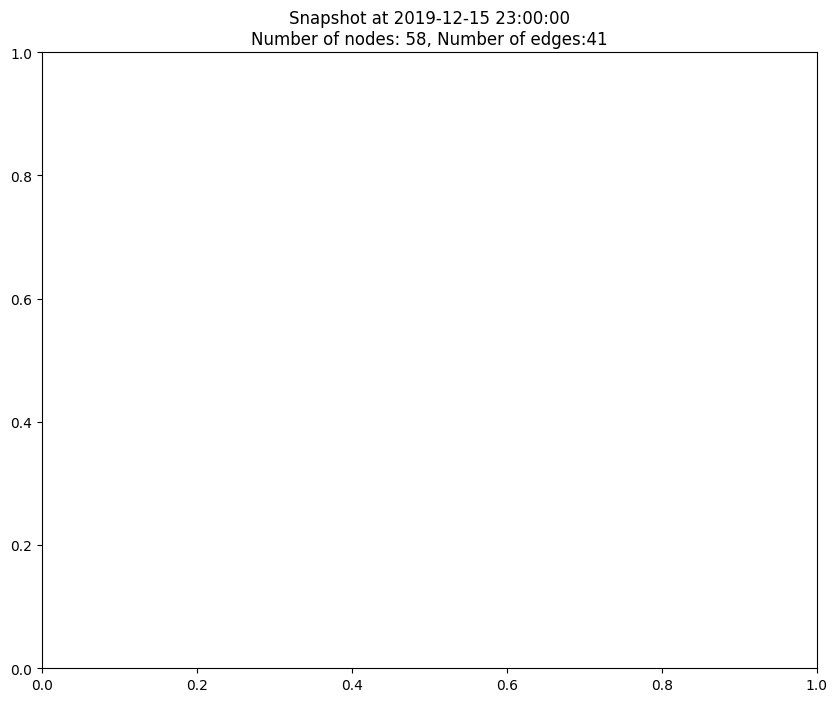

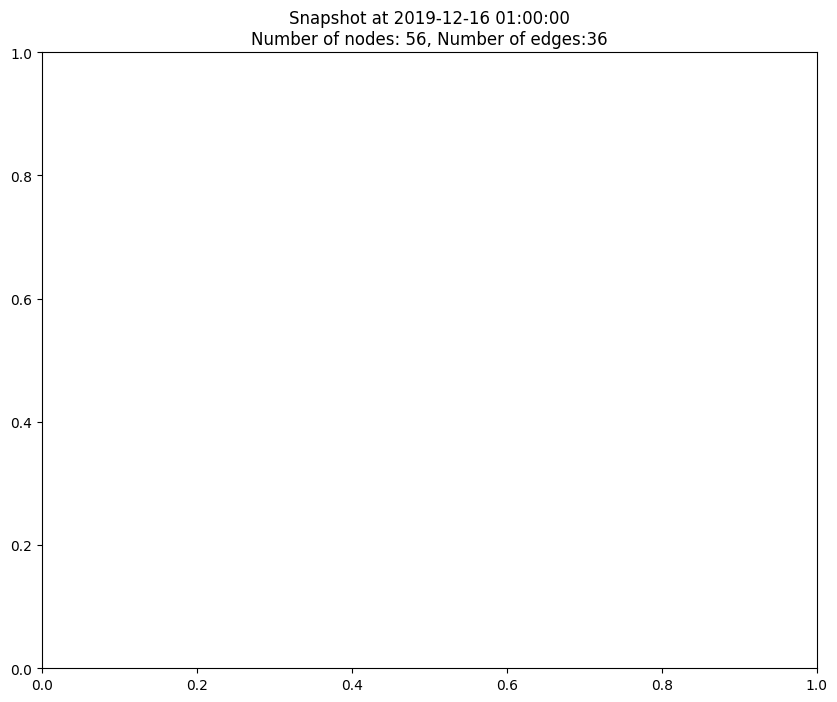

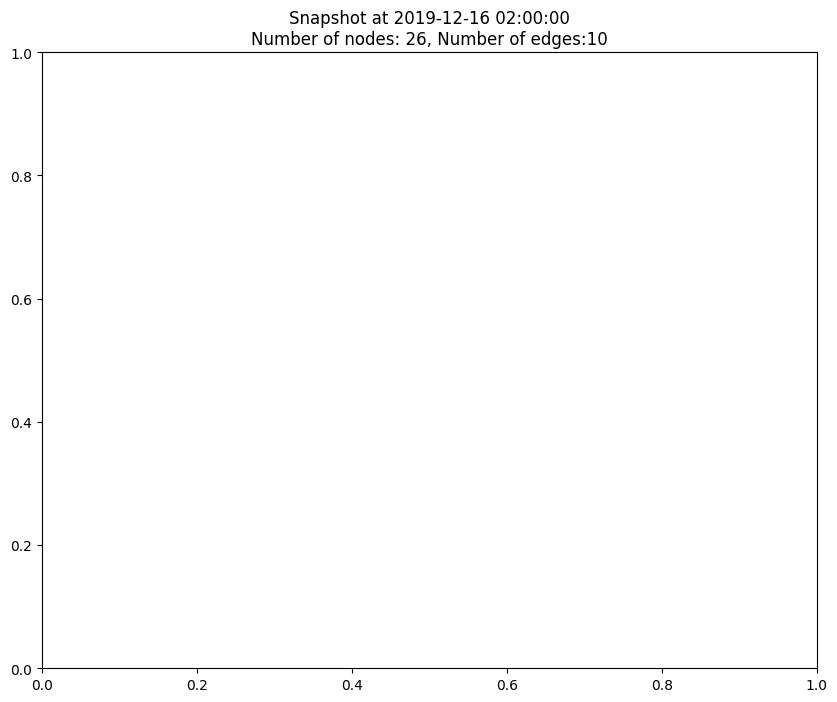

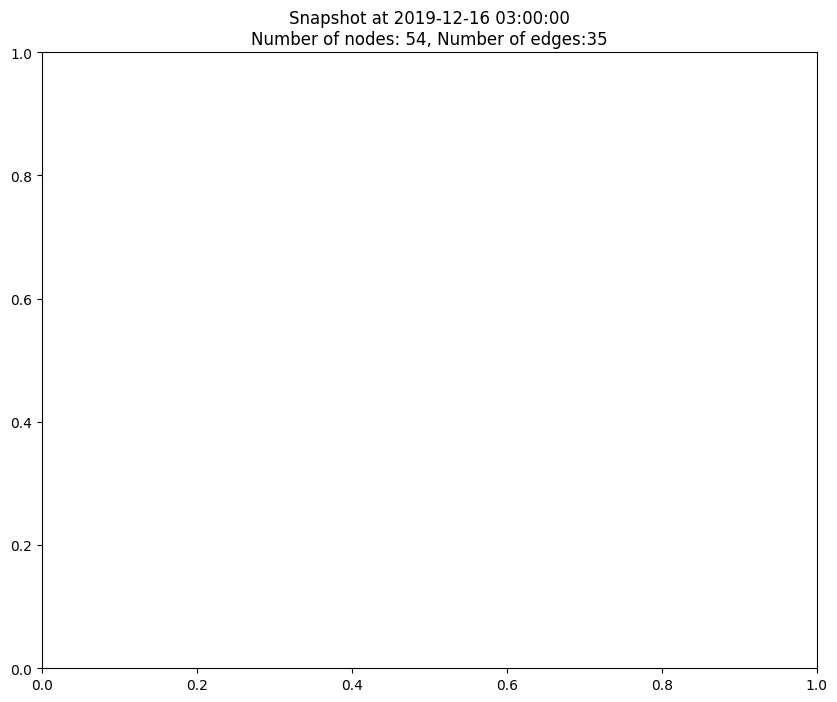

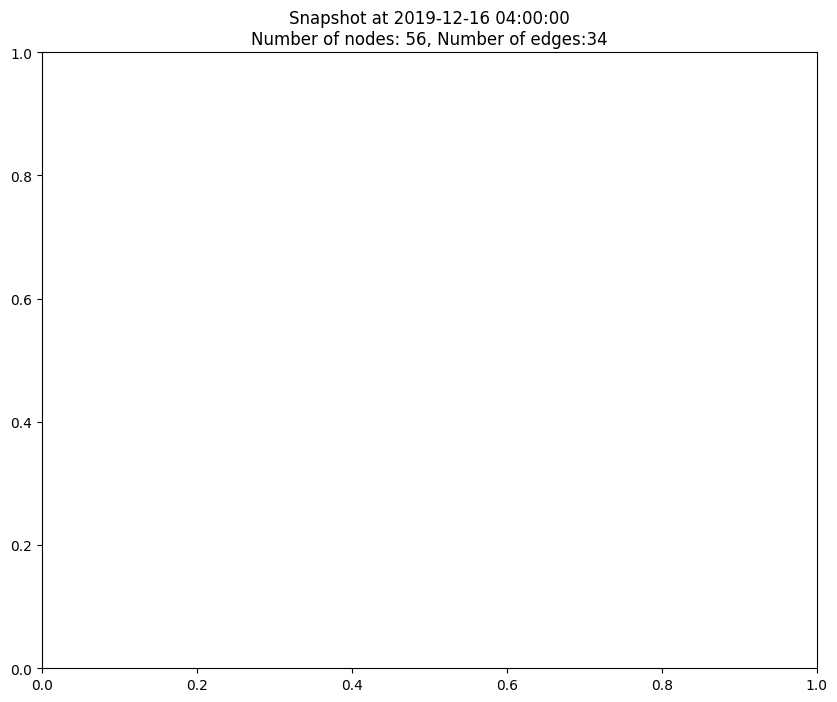

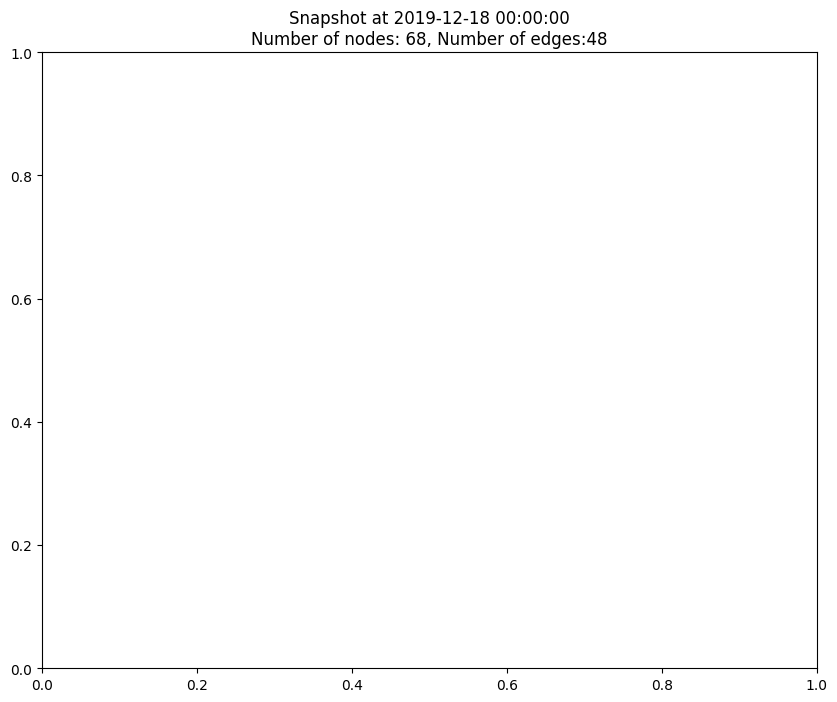

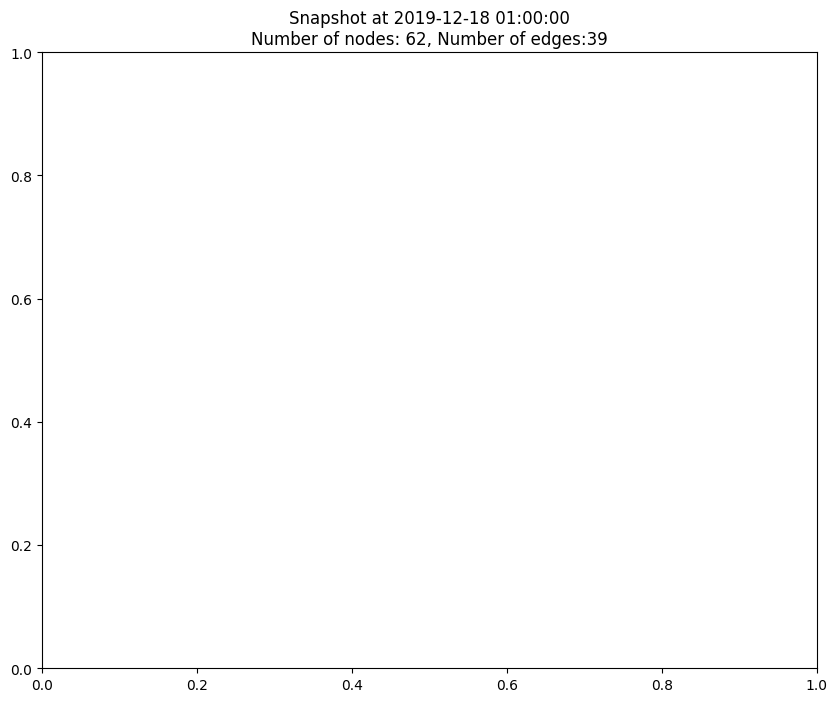

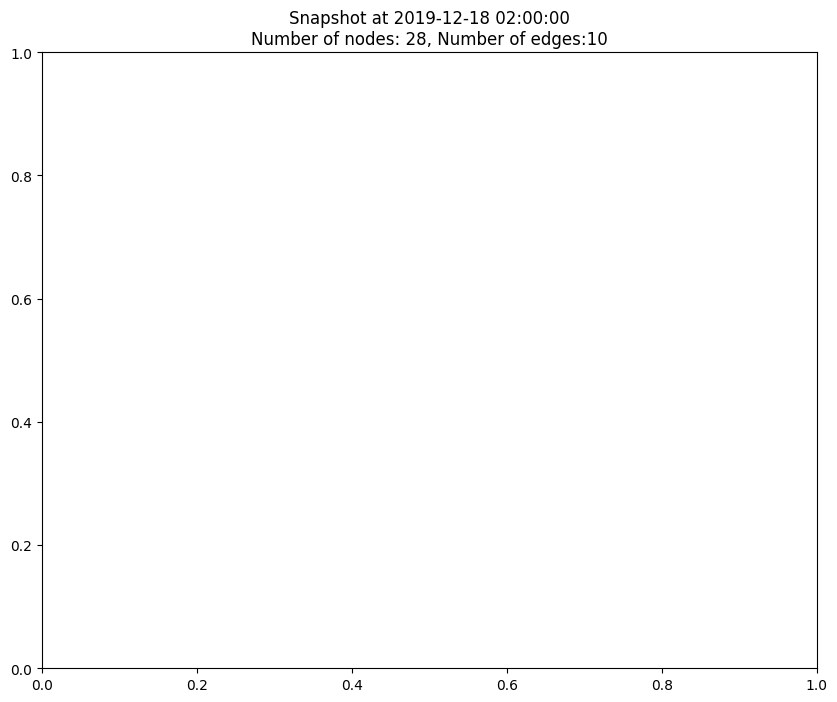

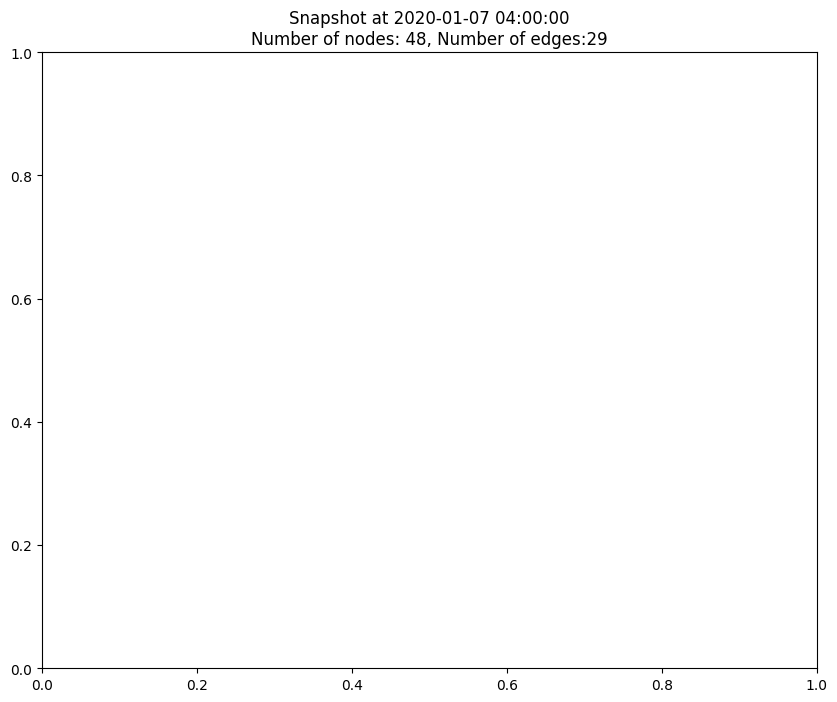

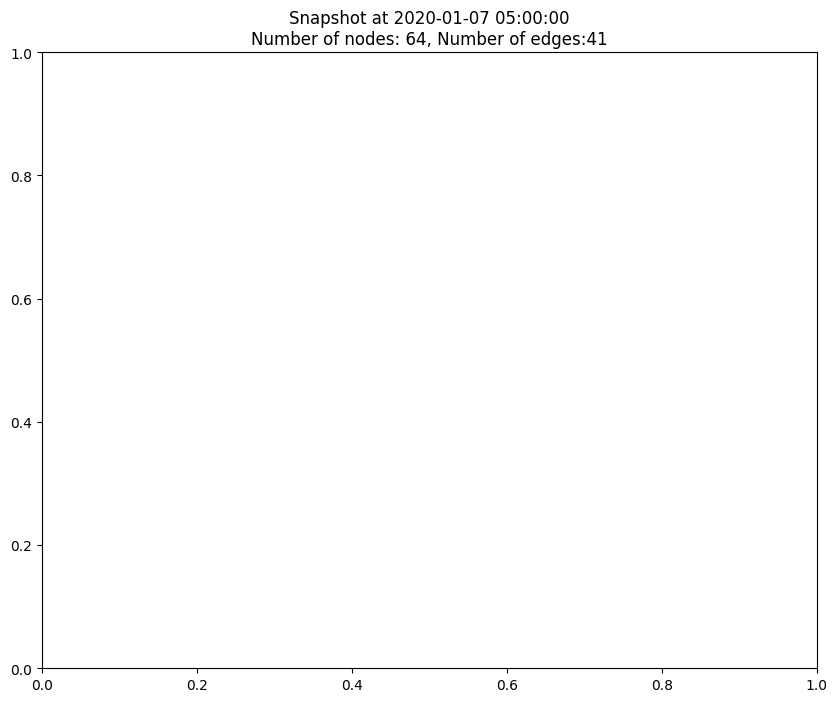

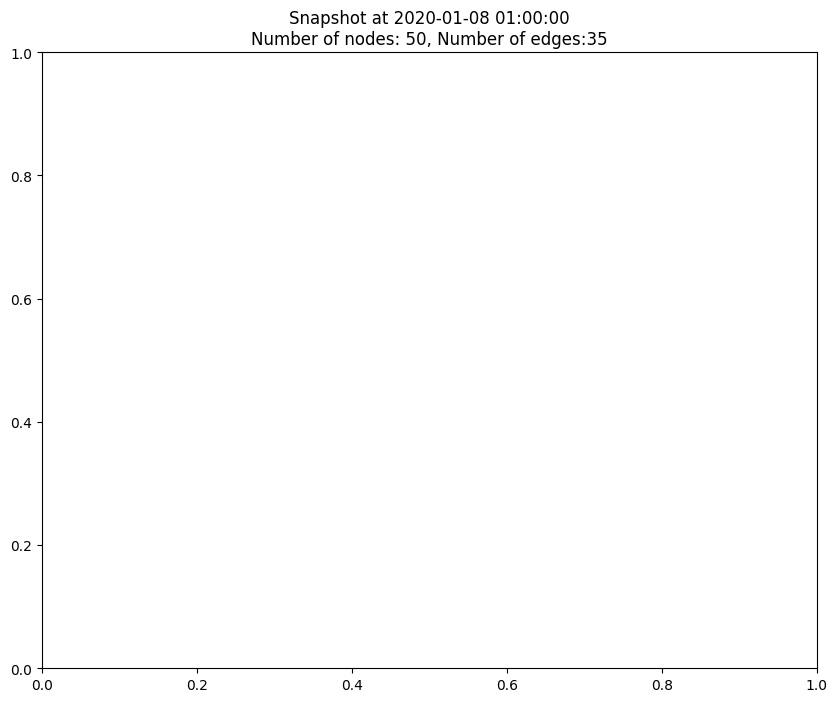

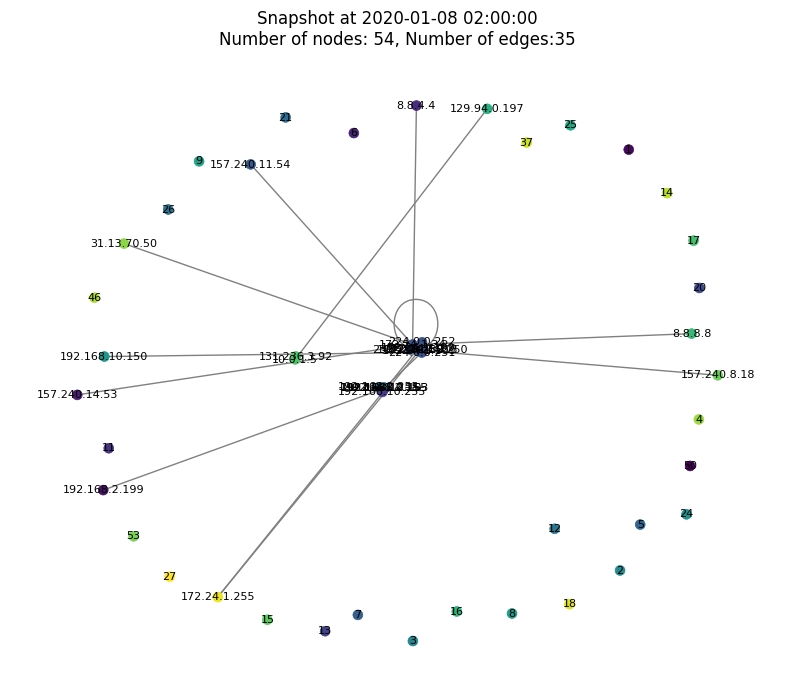

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain

# Load the dataset
df = pd.read_csv('X-IIoTID.csv', low_memory=False)

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df['timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.floor('H')

# Initialize the snapshots dictionary and a dictionary for node IDs
snapshots = {}
node_ids = {}
current_id = 1  # Start with an ID of 1

# Group the DataFrame by the hourly timestamp
for hourly_timestamp, group in df.groupby('timestamp'):
    G = nx.Graph()  # Create a new graph for each hour

    for index, row in group.iterrows():
        # Check if the IP already has an ID assigned, if not, assign a new one
        for ip in [row['Scr_IP'], row['Des_IP']]:
            if ip not in node_ids:
                node_ids[ip] = current_id
                current_id += 1

        src_id = node_ids[row['Scr_IP']]
        dest_id = node_ids[row['Des_IP']]
        src_bytes = int(row['Scr_bytes']) if row['Scr_bytes'].isdigit() else 0
        des_bytes = int(row['Des_bytes']) if row['Des_bytes'].isdigit() else 0
        total_bytes = src_bytes + des_bytes

        # Assuming 'class3' column exists and dictates the label
        node_label_src = 'Normal' if row['class3'] == 'NormalActivity' else 'Attack'
        node_label_dest = 'Normal'  # Assume destinations are 'Normal', adjust as needed
        total_bytes = src_bytes + des_bytes

        G.add_node(src_id, label=node_label_src)
        G.add_node(dest_id, label=node_label_dest)
        G.add_edge(
        row['Scr_IP'],
        row['Des_IP'],
        weight=total_bytes,
        protocol=row['Protocol'],
        src_port=row['Scr_port'],
        des_port=row['Des_port'],
        service=row.get('Service', None)
        # label attribute for edges removed since nodes now carry 'class3' labels
                      )

    snapshots[hourly_timestamp] = G

# Detect communities for each snapshot using the Louvain method
# Detect communities for each snapshot using the Louvain method
for timestamp, graph in snapshots.items():
    # Check if the graph has edges and the edges have weights
    if graph.number_of_edges() > 0 and all('weight' in data for u, v, data in graph.edges(data=True)):
        try:
            partition = community_louvain.best_partition(graph, weight='weight')
            # Add community info to each node in the graph
            for node, comm_id in partition.items():
                graph.nodes[node]['community'] = comm_id
        except ZeroDivisionError:
            print(f"Skipping community detection for snapshot at {timestamp} due to ZeroDivisionError.")
            # Assign a default community for nodes
            for node in graph.nodes():
                graph.nodes[node]['community'] = 0
    else:
        # Assign a default community for nodes
        for node in graph.nodes():
            graph.nodes[node]['community'] = 0

# Visualization loop for each snapshot, now in chronological order
sorted_timestamps = sorted(snapshots.keys())
max_snapshots_to_visualize = 20  # Adjust as needed

for i, timestamp in enumerate(sorted_timestamps):
    if i >= max_snapshots_to_visualize:
        break  # Limit the number of visualized snapshots
    
    graph = snapshots[timestamp]
    
    plt.figure(figsize=(10, 8))
    plt.title(f'Snapshot at {timestamp}\nNumber of nodes: {graph.number_of_nodes()}, Number of edges:{graph.number_of_edges()}')

# Compute layout for visualizing the graph
pos = nx.spring_layout(graph)

# Prepare color map for nodes based on their community
# If community detection was skipped, all nodes will have the default community 0
community_colors = [graph.nodes[node].get('community', 0) for node in graph.nodes()]

# Draw the graph with nodes colored by community
nx.draw(graph, pos, with_labels=True, node_size=50, edge_color="gray", linewidths=0.5, font_size=8, node_color=community_colors)

plt.axis('off')
plt.show()
